##  `Oracle for Shor's algorithm`

In this notebook we will write a way to solve a 2x2 binary Sudoku Puzzle. If the solution exists, we will find it, with high probability, using Grover's algorithm.
A sudoku has two simple rules:
- No column may contain the same value twice
- No row may contain the same value twice

A sudoku will look like the following by assigning to each square a variable:
$$
\begin{array}{|c|c|}
\hline
s_0 & s_1 \\\\
\hline
s_2 & s_3 \\\\
\hline
\end{array} \iff (s_0,s_1,s_2,s_3)\in\mathbb{Z}_2^4
$$

First we notice that there are 16 possible 2 by 2 binary grids and actually only two valid solutions of the Sudoku and they are the following
$$
\begin{array}{|c|c|}
\hline
1 & 0 \\\\
\hline
0 & 1 \\\\
\hline
\end{array}
\quad
\begin{array}{|c|c|}
\hline
0 & 1 \\\\
\hline
1 & 0 \\\\
\hline
\end{array}
$$
We can identify each Sudoku grid with a vector in $\in\mathbb{Z}_2^4$, and thanks to this identification we notice that the solutions are $(1,0,0,1)$ and $(0,1,1,0)$. The idea is to use the Grover's search to reward the valid solutions over the incompatible ones.

In [59]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from qiskit.visualization import matplotlib as _  # Ensures Qiskit sets up its matplotlib styles
import numpy as np

In [49]:
sudoku_rules_list = [[0,1],   
               [0,2],   
               [1,3],   
               [2,3]]   

Following the sudoku rules, each sublist `[i,j]` represents a constraint that **variable i must not be equal to the variable j**.

- `[0,1]`: s0 ≠ s1 (top row)
- `[0,2]`: s0 ≠ s2 (left column)
- `[1,3]`: s1 ≠ s3 (right column)
- `[2,3]`: s2 ≠ s3 (bottom row)

Notice that the XOR function is precisely does that, we can define it using a CX Gate since the values of each row and each columns must be different. Since our condition is **“values must not be equal”**, XOR directly provides the desired output: If XOR = `1`, then the constraint is satisfied.

In [50]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In the next cell, we are constructing a quantum circuit to calculate the **XOR of two input qubits** and store the result in an output qubit. We will do this eventually 4 times for each row and each columns to check the rules according to our sudoku_rules we have defined above.

First, we create two registers:

- One register holds the **two input qubits**, representing the values we want to compare.
- Another register holds the **output qubit**, where we will store the result of the XOR operation.

In [51]:
VectorIn = QuantumRegister(2, name='input')
Outcome = QuantumRegister(1, name='output')
qc = QuantumCircuit(VectorIn, Outcome)
XOR(qc, VectorIn[0], VectorIn[1], Outcome)
#qc.draw('mpl')

Now we create the solver circuit which is the key component before we apply the Grover's search, we will need 4 qubits to store the sudoku $(s_1,s_2,s_3,s_4)$. Additionally we will use 4 ancillas registries (initialized ot 0) for the sudoku rules and one last extra qubit that when measured if 1 we have a solution and of 0 we don't have a solution.

In [55]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='s')
rules_qubits = QuantumRegister(4, name='a')
output_qubit = QuantumRegister(1, name='We Found a Solution!')
qc = QuantumCircuit(var_qubits, rules_qubits, output_qubit)

# Check rules, each rule is a condition that
i = 0
for rule in sudoku_rules_list:
    XOR(qc, rule[0], rule[1], rules_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mcx(rules_qubits, output_qubit)

qc.draw()

s_0: ──■─────────■────────────────────────────────
                        │         │                                
                 s_1: ──┼────■────┼─────────■──────────────────────
                        │    │    │         │                      
                 s_2: ──┼────┼────┼────■────┼─────────■────────────
                        │    │    │    │    │         │            
                 s_3: ──┼────┼────┼────┼────┼────■────┼────■───────
                      ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
                 a_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
                      └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
                 a_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                                └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
                 a_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                                          └───┘└───┘┌─┴─┐┌─┴─┐  │  
                 a_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                                    └───┘└───┘┌─┴─┐
We Found a Solution!: ────────────────────────────────────────┤ X ├
                                                              └───┘

Notice that in the above the final position of the 4 ancillas can be one only if all the rules are checked which means that we have indeed a solution, so we use a multi controlled Toffoli gates  with our output qubit to assert if we have a solution!

We are now ready to construct our Oracle combining what we have done so far! This step means that our oracle checks if the current sudoku assignment is a valid solution. If it is, it flips the output qubit.

Because the output qubit is set up in a special superposition state, flipping it actually creates a **phase flip** on the entire solution state. This phase flip is how Grover’s algorithm “marks” correct solutions, allowing the algorithm to amplify their probability and find them efficiently.

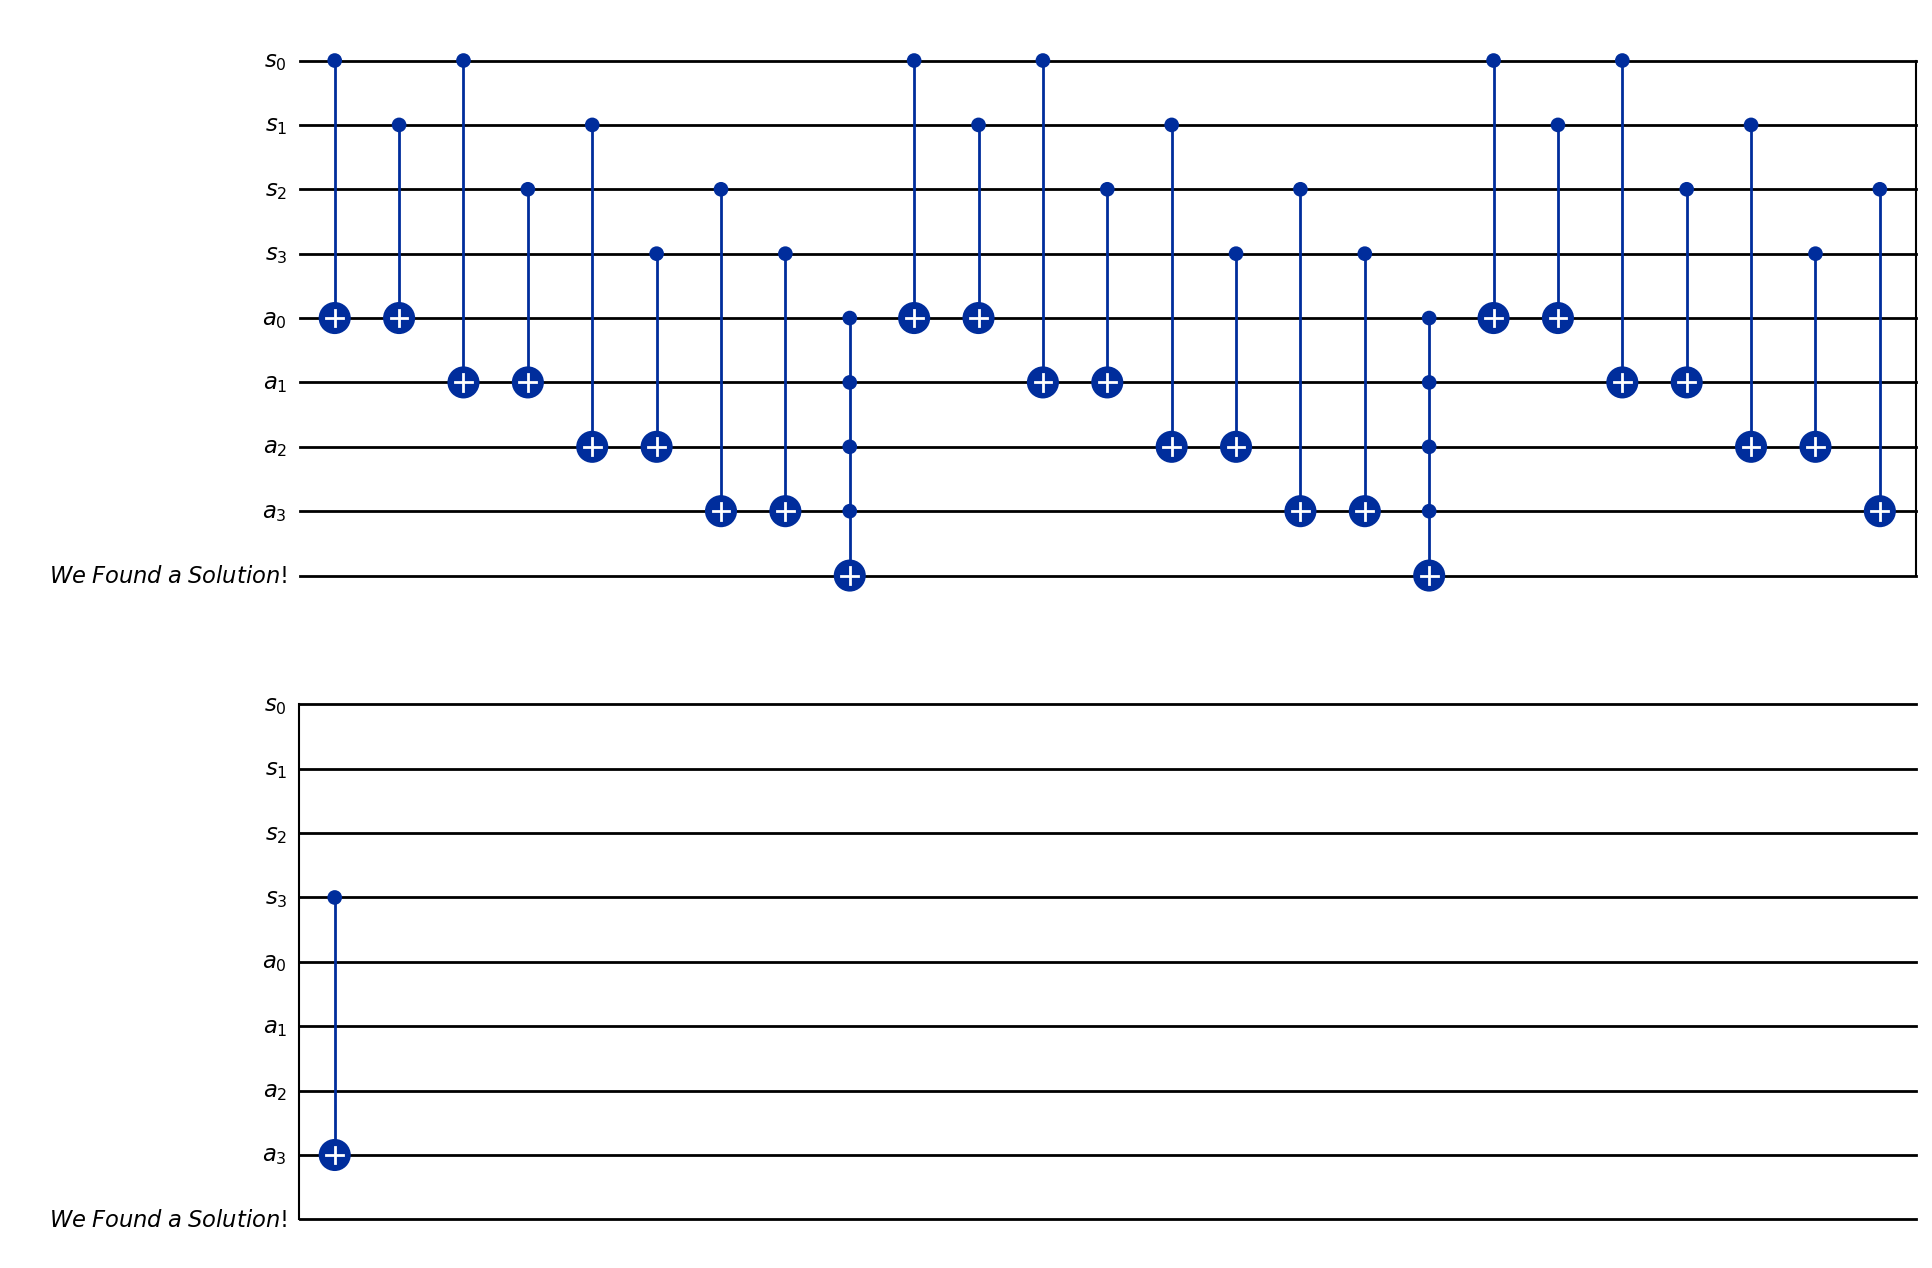

In [56]:
def sudoku_oracle(qc, sudoku_rules_list, rules_qubits):
    # Check rules, each rule is a condition that must be satisfied
    i=0
    for clause in sudoku_rules_list:
        XOR(qc, clause[0], clause[1], rules_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(rules_qubits, output_qubit)

    # Uncompute the rules to reset ancillas bits to 0
    i = 0
    for rule in sudoku_rules_list:
        XOR(qc, rule[0], rule[1], rules_qubits[i])
        i += 1

sudoku_oracle(qc, sudoku_rules_list, rules_qubits)
qc.draw('mpl')

We will now construct the diffuser circuit: The **diffuser** in Grover's algorithm is an essential step that helps us actually find the correct solution. After the oracle marks the solution states by flipping their phase, the diffuser amplifies their probabilities. It does this by reflecting all the quantum state amplitudes around their mean value, which increases the amplitudes of the solutions and decreases the amplitudes of the non-solutions. 

This process makes it much more likely that when we measure the qubits, we will get a solution. Without the diffuser, the phase flip from the oracle would not lead to a higher chance of measuring the correct answer. Together, the oracle and diffuser steps are repeated multiple times to maximize the probability of success in Grover’s algorithm.

The general formula is given by 
$$
H^{\otimes 4}\circ
X^{\otimes 4}\circ
C^3Z\circ
X^{\otimes 4}\circ
H^{\otimes 4}
$$

In [57]:
## Diffuser Circuit 
qr = QuantumRegister(size=4, name = "d");

diffuser_qc = QuantumCircuit(qr, name = "Diffuser");
diffuser_qc.h(qr);
diffuser_qc.x(qr);
diffuser_qc.mcp(np.pi, qr[0:-1], qr[-1])
diffuser_qc.x(qr);
diffuser_qc.h(qr);

diffuser = diffuser_qc.to_gate(); #$ here we make it a gate to use it later in the future after the oracle.
diffuser_qc.draw()

┌───┐┌───┐       ┌───┐┌───┐
d_0: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │     ├───┤├───┤
d_1: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │     ├───┤├───┤
d_2: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     ├───┤├───┤ │P(π) ├───┤├───┤
d_3: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
     └───┘└───┘       └───┘└───┘

We are now ready to put everything together and implement the full algorithm using the Grover's search. To do so we first initialize our states with an Hadamard gate and initialize the output state to -, we then apply in sequence the oracle and the diffuser we have defined. For completion we will redefine all the variables:

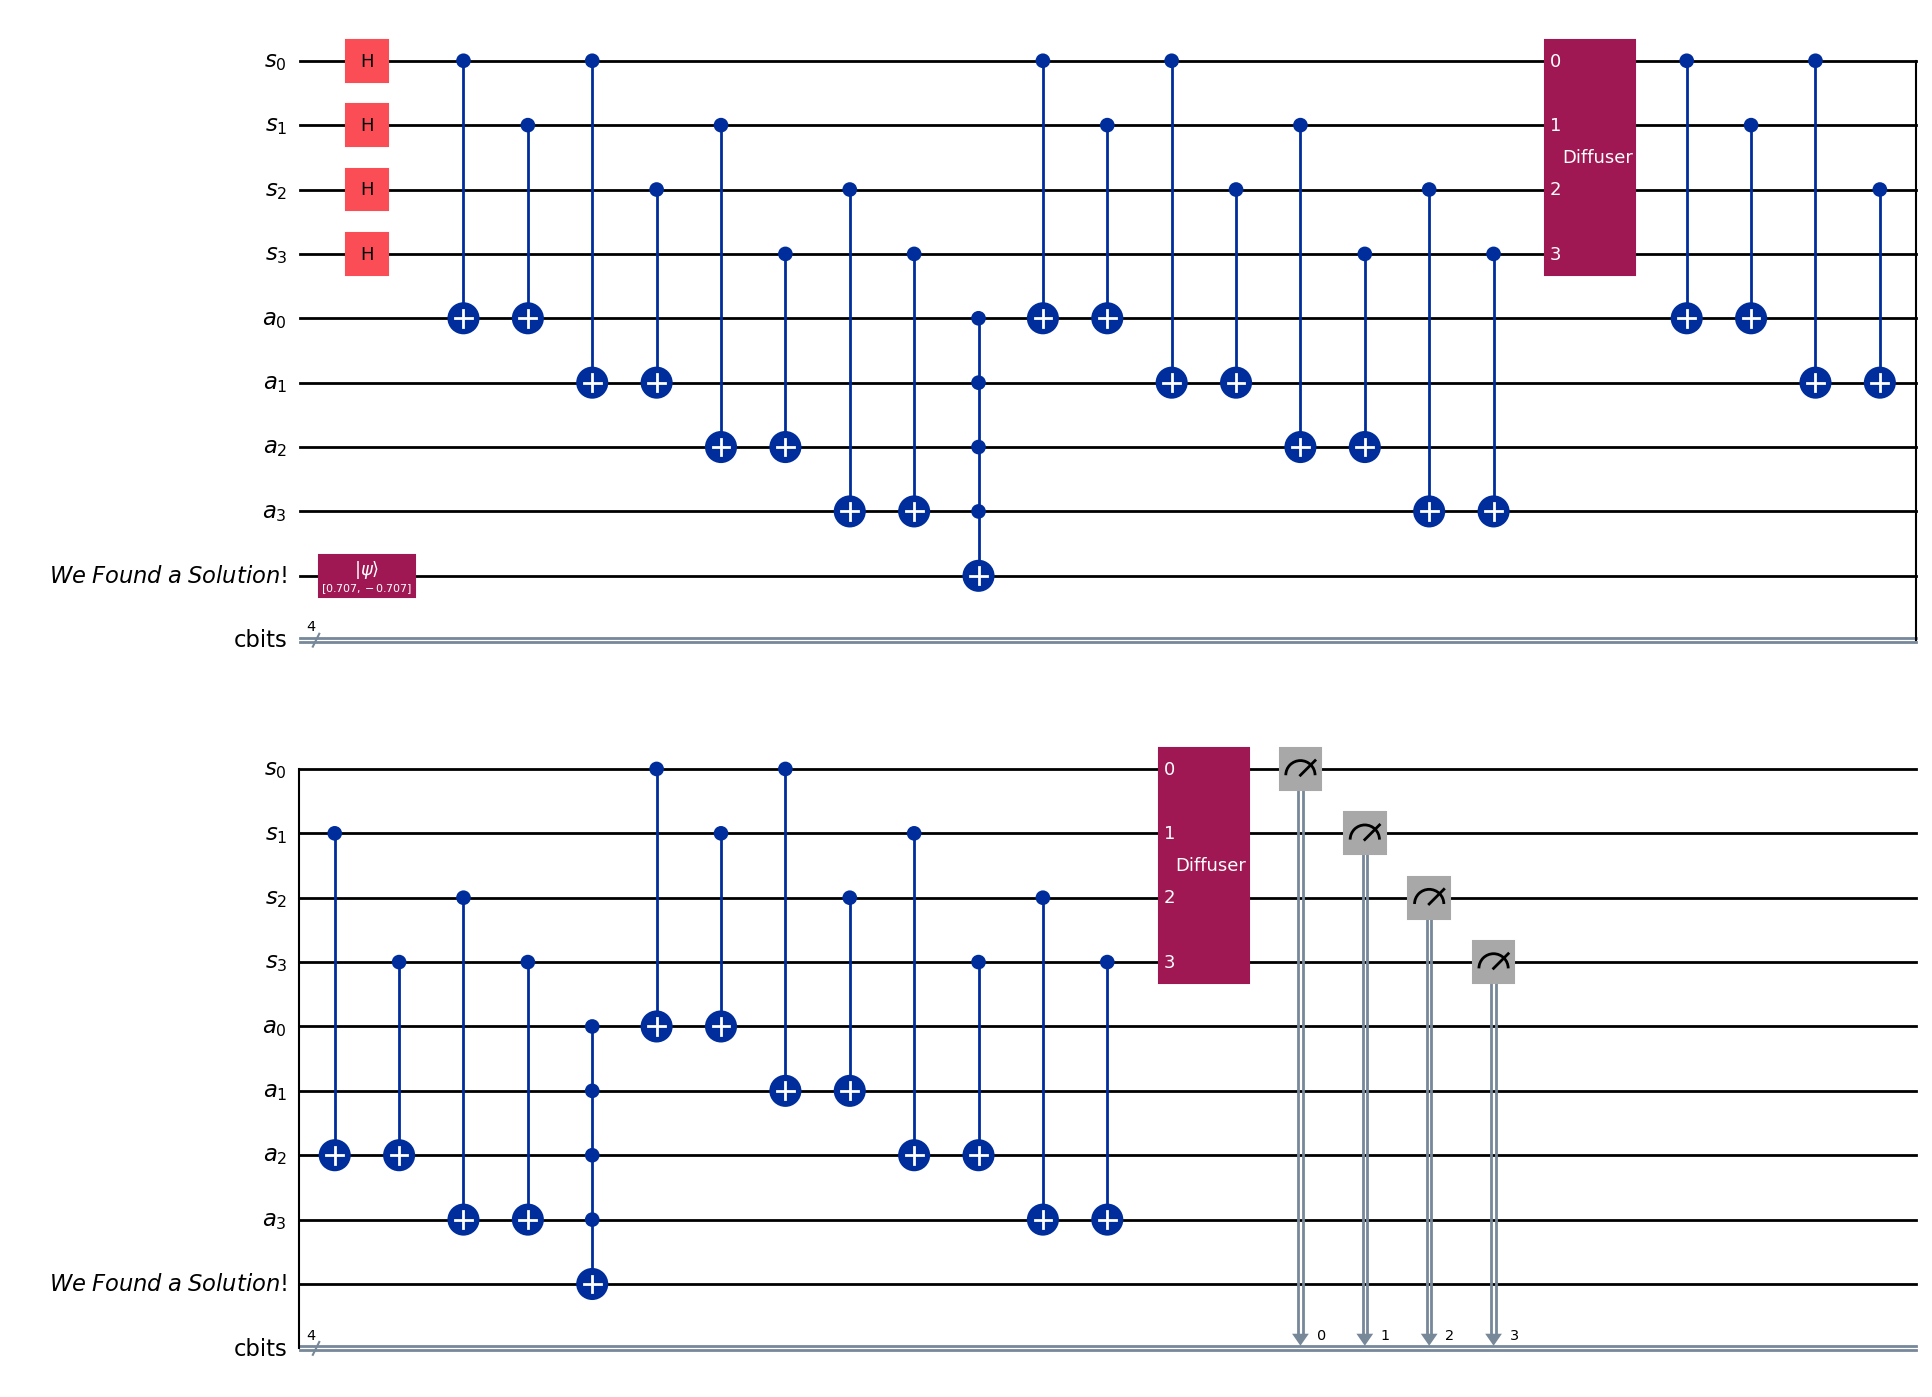

In [ ]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='s')
rules_qubits = QuantumRegister(4, name='a')
output_qubit = QuantumRegister(1, name='We Found a Solution!')
qc = QuantumCircuit(var_qubits, rules_qubits, output_qubit)
cbits=ClassicalRegister(4, name='cbits') # we only need 4 classical bits to store the solution, since we have 4 variables
qc = QuantumCircuit(var_qubits, rules_qubits, output_qubit, cbits)

qc.initialize([1, -1]/np.sqrt(2), output_qubit) # Initialize output qubit to |->

qc.h(var_qubits) # Apply Hadamard to the variable qubits to create superposition

sudoku_oracle(qc, sudoku_rules_list, rules_qubits) # Apply the oracle to check the sudoku rules

qc.append(diffuser, [0,1,2,3]) # Apply the diffuser to amplify the solution

sudoku_oracle(qc, sudoku_rules_list, rules_qubits) # Apply the oracle again to check the sudoku rules

qc.append(diffuser, [0,1,2,3]) # Apply the diffuser again to amplify the solution

qc.measure(var_qubits, cbits)   # measure the variable qubits to get the solution

qc.draw( output='mpl')







The optimal probability is found for system with $m$ solutions that uses $N$ qubits when we apply the algorithm twice since 2 is the integer part of $\frac{\pi}{4}\sqrt(\frac{N}{m})$. In this case we have $N=4$ and $m=2$.

We need now make sure that the algorithm we have defined works to understand the rules and finds the (only 2) correct solutions. To do so we plot the probabilities

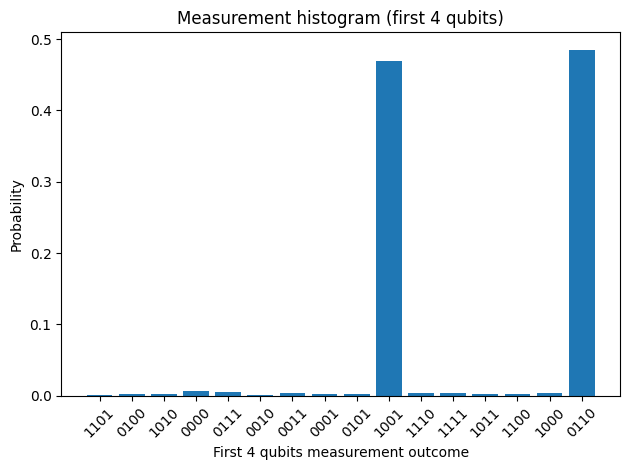

In [97]:
#pip install qiskit-aer
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler

backend = Aer.get_backend('qasm_simulator')

sampler = Sampler()

# Example usage with a QuantumCircuit 'qc'
job = sampler.run(qc)
result = job.result()

quasi_probs = result.quasi_dists[0]

# Number of measured qubits
n_qubits = qc.num_qubits

# Define how many bits you want to display (first k qubits)
k = 4

# Convert integer keys to bitstrings, reverse if desired, and slice to first k bits
counts = {format(k_int, f'0{n_qubits}b')[::-1][:k]: v for k_int, v in quasi_probs.items()}

# Plot histogram with angled x-axis labels
plt.bar(counts.keys(), counts.values())
plt.xlabel(f'First {k} qubits measurement outcome')
plt.ylabel('Probability')
plt.title('Measurement histogram (first 4 qubits)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The two bits with higher probablity are indeed the one that have a sudokuy solution as mentioned before, namely 1001 and 0110.